## Source sensitivity in model


\begin{equation}
   S(F, \Omega) \equiv p(d = 1| F, \Omega)
\end{equation}

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pylab as plt
import numpy as np
import torch
import swyft
import swyft.lightning as sl
import sims
from networks import NetworkSensitivity

from icecream import ic
plt.style.use(['science', 'notebook'])

Load back model for r_2

In [3]:
simulator = sims.ToyFermi(npix = 128)
shapes, dtypes = simulator.get_shapes_and_dtypes()
store = swyft.ZarrStore("/project/fermi_data/neurips_original_d.zarr")

def hook(out):
    N = int(out['pdp'][0])
    idx = torch.randint(N, (1,)) # index in simulated source range
    out['source'] = torch.from_numpy(out['pdc'][idx]).clone() # (3,)
    # make sure to pick source simulated in image
    while torch.sum((out['source'][:2]>40)+(out['source'][:2]<-40), -1):
        idx = torch.randint(N, (1,)) # index in simulated source range
        out['source'] = torch.from_numpy(out['pdc'][idx]) # (3,)
    out['source'][2] = np.log10(out['source'][2]) # use log10(F)
    out['d_source'] = np.array([out['d'][idx]])*1. # (1,)   
    out = sl.to_numpy32(out)
    return out

dl_test = store.get_dataloader(idx_range = [36000, 40000], batch_size = 32, num_workers = 8, on_after_load_sample=hook)

trainer = swyft.SwyftTrainer(accelerator = 'gpu', gpus=1)
ckpt_path = swyft.best_from_yaml("./lightning_logs/neurips_sensitivity/version_0/checkpoints/model.yaml")
network_d = NetworkSensitivity()
trainer.test(network_d, dl_test, ckpt_path = ckpt_path);

/home/noemiam/.pyenv/versions/3.10.0/envs/fermi-3.10.0/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at ./lightning_logs/neurips_sensitivity/version_0/checkpoints/epoch=10-val_loss=-0.16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./lightning_logs/neurips_sensitivity/version_0/checkpoints/epoch=10-val_loss=-0.16.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.027495432645082474
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [4]:
# Prior
d_values = torch.from_numpy(store['d'][..., 0] * np.array(1.))
d_tot = d_values.shape[0]
prior_d1 = d_values.sum() / d_tot
prior_d0 = 1 - prior_d1
print(prior_d1, prior_d0)

tensor(0.1573, dtype=torch.float64) tensor(0.8427, dtype=torch.float64)


In [5]:
samples = simulator.sample(10000, targets={'pdc'}) 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 6580.12it/s]


In [6]:
def hook(out, test=False, d=1.):
    N = int(out['pdp'][0])
    idx = torch.randint(1, (1,)) # fix index to be the same for r2(d=1) and r2(d=0)
    out['source'] = torch.from_numpy(out['pdc'][idx]).clone() # (3,)
    out['source'][2] = np.log10(out['source'][2]) # use log10(F)
    
    if test:
        out['d_source'] = np.array([d]) # trick label into being always d=1, we want to estimate p(d=1| F...)
    else:
        out['d_source'] = np.array([out['d'][idx]])*1. # (1,)  
        
    out = sl.to_numpy32(out)
    return out

In [7]:
log10f, logr2_1, logr2_0 = torch.zeros(10000), torch.zeros(10000), torch.zeros(10000)
for i in range(10000):
    data1 = hook(samples[i], test=True, d=1.)
    data0 = hook(samples[i], test=True, d=0.)
    for (k1, v1), (k0, v0) in zip(data1.items(), data0.items()):
        data1[k1] = torch.tensor(v1).unsqueeze(0)
        data0[k0] = torch.tensor(v0).unsqueeze(0)
    assert data1['source'][0, 2] == data0['source'][0, 2]
    log10f[i] = data1['source'][0, 2]
    logr2_1[i] = network_d(data1, data1)['re_d'].logratios.detach()
    logr2_0[i] = network_d(data0, data0)['re_d'].logratios.detach()

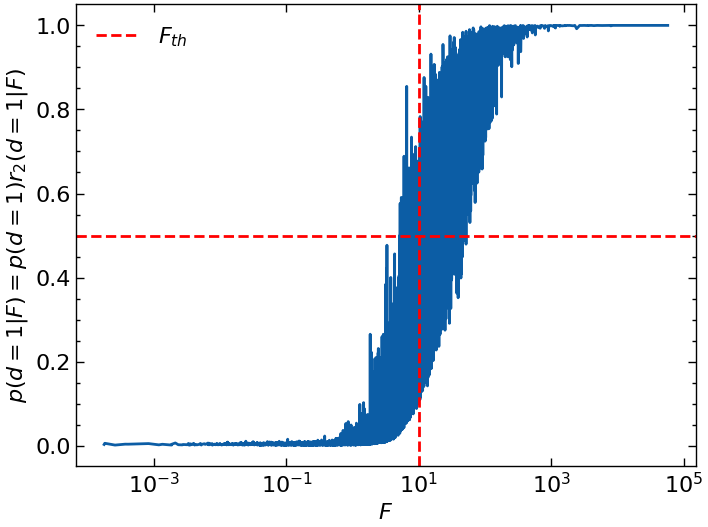

In [8]:
plt.semilogx(
    10**log10f[log10f.argsort()], 
    torch.sigmoid(((prior_d1*logr2_1.exp())/(prior_d0*logr2_0.exp())).log()) [log10f.argsort()]
);
plt.xlabel(r'$F$')
plt.ylabel(r'$p(d=1|F) = p(d=1) r_2(d=1| F)$')
plt.axvline(10., c='r', ls='--', label=r"$F_{th}$")
plt.axhline(0.5, c='r', ls='--')
plt.legend();

Simulate

In [9]:
psc_det = torch.tensor(np.load('neurips_ps_det.npy'))
bounds = sims.ToyFermiBound(detected = psc_det, threshold = 17.8)
simulator = sims.ToyFermiSensitivity(npix = 128, bounds=bounds, sensitivity_function=network_d)

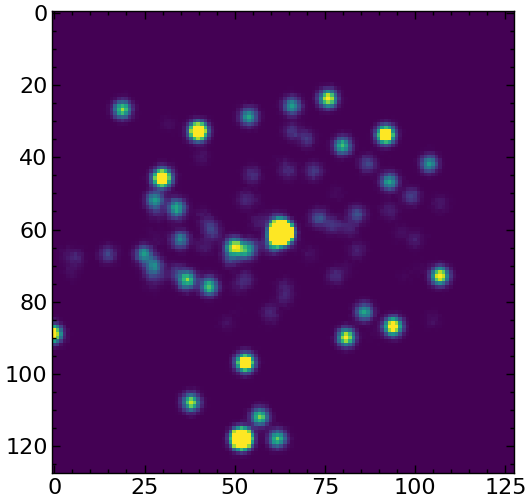

In [10]:
sample = simulator.sample()
plt.imshow(sample['data'], vmin=0, vmax=10)